In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output
print(check_output(['ls', '../input/iceberg']).decode('utf-8'))

sample_submission.csv
statoil-iceberg-classifier-challenge.zip
test.json
train.json



This kernel is specifically is for Beginners who want to experiment building CNN using Keras(- Torch). By using this Kernel, you can expect to get good score and also learn torch. Torch is simple frameworks where we can initialize the model and keep stacking the layers we want. It makes building deep neural networks very easy.

In [2]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = 10,10
%matplotlib inline

In [3]:
# Load the data
train = pd.read_json('../input/iceberg/train.json')
test = pd.read_json('../input/iceberg/test.json')
train.shape, test.shape

((1604, 5), (8424, 4))

In [4]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
test.head()

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


# Intro about the Data
Sentinet -1 sat is at about 680Km above earth. Sending pulses of signals at a particular angle of incidence and then recording it back. Basically those reflected signals are called backsacatter. The data we have been given is backscatter coefficient which is the conventional form of backscatter coefficient given by:
$σo (dB) = βo (dB) + 10log10 [ sin(ip) / sin (ic)] $

where

1. ip = is angle of incidence for a particular pixel
2. ic = is angle of incidence for center of the image
3. K =constant.

We have been given $σo$ directly in the data

# Now coming to the features of $σo$
Basically  σo varies with the surface on which the signal is cattered from. For example, for a particular angle of incidence, it varies like:
* WATER ................ SETTLMENTS ................ ARGICULTURE ................ BARREN
1. HH: -27.001 ................ 2.70252 ................. -12.7952 ................ -17.25790909

2. HV: -28.035 ................ -20.2665 .................. -21.4471 ................. -20.019

As you can see, the HH component varies a lot but HV doesn't. I don't have the data for scatter from ship, but being a metal object, it should vary differently as compared to ice object.

## WTF is HH HV?
Ok, so this Sentinal Settalite is equivalent to RISTSAT(an Indian remote sensing Sat) and they only Transmit pings in H polarization, AND NOT IN V polarization. Those H-pings gets scattered, objects change their polarization and return as a mix of H and V. Since Sentinel has only H-transmitter, return signals are of the form of HH and HV only. Don't ask why VV is not given (because Sentinel don't have V-poing transmitter).

Now coming to features, for the purpose of this demo code, I am extracting all two bands and taking avg of them as 3rd channel to create a 3-channel RGB equivalent.

In [47]:
# Genereate the training data
# Create 3 bands having HH, HV and avg of both
def make_image(df):
    X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in df['band_1']])
    X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in df['band_2']])
    
    X_train = np.concatenate([X_band_1[:,:,:,np.newaxis], 
                    X_band_2[:,:,:,np.newaxis], 
                   ((X_band_1+X_band_2)/2)[:,:,:,np.newaxis]], axis=-1)
    return X_train
X_train = make_image(train)
X_test = make_image(test)
X_train.shape, X_test.shape

((1604, 75, 75, 3), (8424, 75, 75, 3))

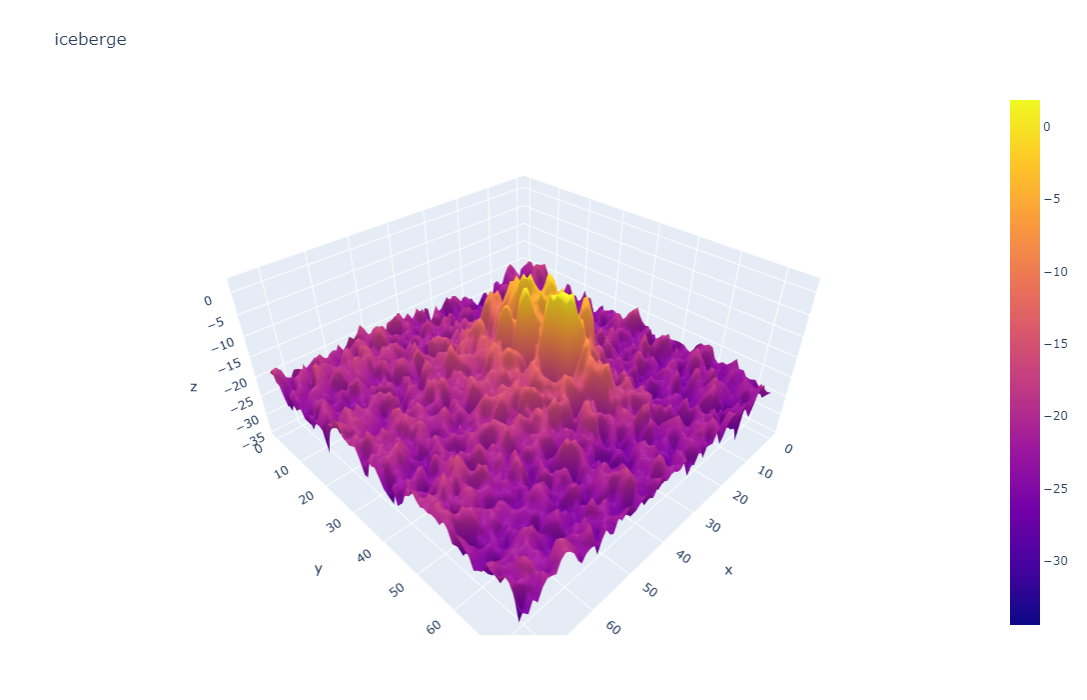

In [7]:
# Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):
    data=[go.Surface(z=c)]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(l=65,r=50,b=65,t=90)
    )
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12], 'iceberge')

That's a cool iceberg we have. Remember, in radar data, the shape of the iceberg is going to be like a mountain as shows in here. Since this is not a  actual image but scatter from radar, the shape is going to have peaks and distortions like these. The shape of the ship is going to be like a point, may be like a elongated point. From here, the strucural differences arise and we can exploit those differences using a CNN. It would be helpful if we can create composite image using the backscatter from radar.

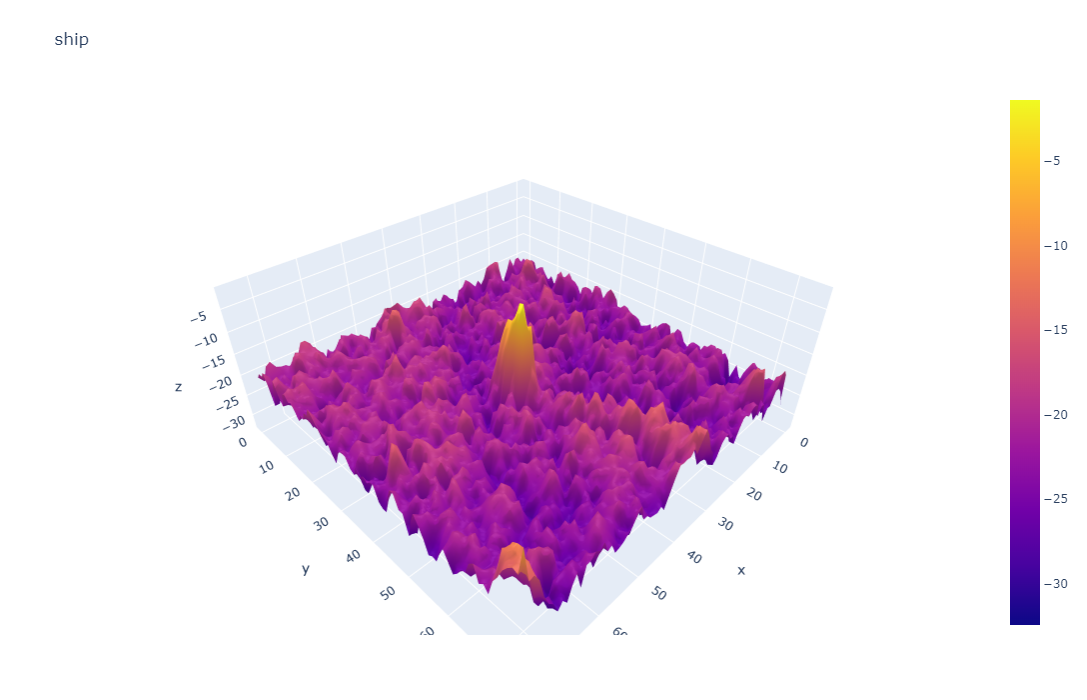

In [8]:
plotmy3d(X_band_1[14], 'ship')

That's a ship, looks like a elongated point. We don't have much resolution in images to visualize the shape of the ship. However, cNN is here to help. There are few papers on ship iceberg classification like this: http://elib.dlr.de/99079/2/2016_BENTES_Frost_Velotto_Tings_EUSAR_FP.pdf

However their data have much better resolution so I don't feel that the CNN they used would be suitable here.

Get back to building a CNN using PyTorch. Much better framework then others. You will enjoy for sure.

In [9]:
import torch
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(CNN, self).__init__()
        self.conv1 = block(in_channels=in_channels, out_channels=64, kernel_size=3, stride=2)
        self.conv2 = block(64, 128, 3, 2)
        self.conv3 = block(128, 128, 2, 2)
        self.conv4 = block(128, 64, 2, 2)
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, out_channels)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = x.reshape(x.shape[0], -1) # (n, 256)
        x = self.classifier(x)
        return x
        
class block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size, stride)
        # self.dropout = nn.Dropout(0.2)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        # x = self.dropout(x)
        x = self.bn(x)
        return x

In [11]:
import pytorch_model_summary

model=CNN()
print(pytorch_model_summary.summary(model, torch.zeros(1, 3, 75, 75), show_input=True))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
           block-1       [1, 3, 75, 75]           1,920           1,920
           block-2      [1, 64, 36, 36]          74,112          74,112
           block-3     [1, 128, 16, 16]         147,840         147,840
           block-4       [1, 128, 7, 7]          73,920          73,920
          Linear-5             [1, 256]          65,792          65,792
            ReLU-6             [1, 256]               0               0
         Dropout-7             [1, 256]               0               0
          Linear-8             [1, 256]          65,792          65,792
            ReLU-9             [1, 256]               0               0
        Dropout-10             [1, 256]               0               0
         Linear-11             [1, 256]             514             514
Total params: 429,890
Trainable params: 429,890
Non-trainable p

In [12]:
# train/valid split
y_train = train['is_iceberg'].to_numpy()
X_train = X_train.transpose(0,3,1,2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1203, 3, 75, 75), (401, 3, 75, 75), (1203,), (401,))

In [13]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('device tpye is', device)

# hyperparameter
PATH = './weights/'
num_epochs = 50
batch_size = 32
learning_rate = 1e-2

device tpye is cuda


In [14]:
# tensor dataset
X_train = torch.from_numpy(X_train).float()
X_valid = torch.from_numpy(X_valid).float()
y_train = torch.from_numpy(y_train)
y_valid = torch.from_numpy(y_valid)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

# loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=401, shuffle=False)

In [15]:
def valid(valid_loader, model):
    num_corrects = 0
    num_samples = 0
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_corrects += (predictions==y).sum()
            num_samples += x.shape[0]
    return num_corrects/num_samples*100

In [32]:
# model & loss & optimize
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train
model.train()
train_accuracy = []
valid_accuracy = []
print('Training Start')
for epoch in range(num_epochs):
    losses = []
    corrects = 0
    total = 0
    
    for i, (ice_imgs, labels) in enumerate(train_loader):
        # GPU
        ice_imgs, labels = ice_imgs.to(device), labels.to(device)
        
        # forward
        scores = model(ice_imgs)
        loss = criterion(scores, labels)
        losses.append(loss.item()) # running loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Running Accuracy
        _, predictions = scores.max(1)
        correct = (predictions == labels).sum()
        corrects += correct.item()
        total += ice_imgs.shape[0]
        
    
    train_acc = corrects/total*100
    valid_acc = valid(valid_loader, model)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc.item())
    print('Epoch:[{}/{}] \tLoss:{:.6f}\tTrain acc:{:.2f}%\tValid acc:{:.2f}'.format(
        epoch+1,num_epochs,sum(losses)/len(losses),train_acc,valid_acc)  )
    if (epoch+1) % 5 == 0:
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':epoch+1,
            'loss': sum(losses)/len(losses),
            'accuracy':corrects/total*100
        }, f'{PATH}/CNN_{epoch+1}.pth')
    
        

Training Start
Epoch:[1/50] 	Loss:0.613377	Train acc:64.84%	Valid acc:63.34
Epoch:[2/50] 	Loss:0.588498	Train acc:66.75%	Valid acc:75.31
Epoch:[3/50] 	Loss:0.518993	Train acc:72.32%	Valid acc:83.04
Epoch:[4/50] 	Loss:0.395235	Train acc:80.38%	Valid acc:84.54
Epoch:[5/50] 	Loss:0.370083	Train acc:84.54%	Valid acc:85.29
Epoch:[6/50] 	Loss:0.329925	Train acc:84.70%	Valid acc:84.04
Epoch:[7/50] 	Loss:0.371654	Train acc:84.54%	Valid acc:83.54
Epoch:[8/50] 	Loss:0.304469	Train acc:86.62%	Valid acc:88.28
Epoch:[9/50] 	Loss:0.310652	Train acc:85.95%	Valid acc:91.02
Epoch:[10/50] 	Loss:0.315922	Train acc:87.20%	Valid acc:89.03
Epoch:[11/50] 	Loss:0.300149	Train acc:86.87%	Valid acc:85.54
Epoch:[12/50] 	Loss:0.309593	Train acc:88.03%	Valid acc:80.30
Epoch:[13/50] 	Loss:0.363285	Train acc:84.46%	Valid acc:85.54
Epoch:[14/50] 	Loss:0.300676	Train acc:87.78%	Valid acc:85.79
Epoch:[15/50] 	Loss:0.315953	Train acc:88.28%	Valid acc:89.53
Epoch:[16/50] 	Loss:0.287487	Train acc:89.69%	Valid acc:89.03
Ep

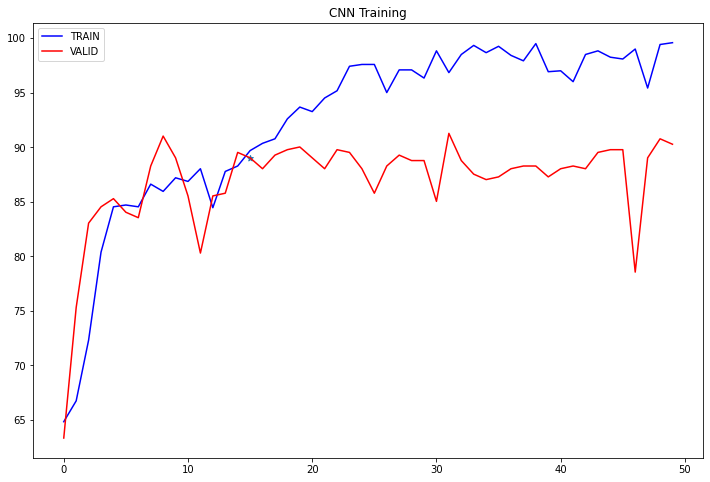

In [42]:
# xrange = np.arange(50)
plt.figure(figsize=(12,8))
plt.plot(train_accuracy, color = 'blue', label='TRAIN')
plt.plot(valid_accuracy, color = 'red', label='VALID')
plt.scatter(x=15, y=valid_accuracy[15], marker='*')
plt.title('CNN Training')
plt.legend()
plt.show()

In [54]:
X_test = make_image(test)
X_test = X_test.transpose(0,3,1,2)
X_test = torch.from_numpy(X_test)
X_test = torch.from_numpy(X_test).float()

test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = CNN().to(device)
checkpoints = torch.load(f'{PATH}/CNN_15.pth')
model.load_state_dict(checkpoints['model'])

predictions = []
with torch.no_grad():
    for x in test_loader:
        x = x[0].to(device)

        scores = model(x)
        _, prediction = scores.max(1)
        
        predictions.extend(prediction.detach().cpu().numpy())

In [103]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predictions
submission.to_csv('sub.csv', index=False)